<a href="https://colab.research.google.com/github/Leo-Ram/Monitoreo/blob/master/btcfinmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trainin

In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from matplotlib import pyplot as plt

# Download Bitcoin historical data at 1-minute intervals
df = yf.download('BTC-USD', start='2025-03-03', end='2025-03-10', interval='1m')



#btc_data.to_csv('his7dias.csv', index=False)

[*********************100%***********************]  1 of 1 completed


Preparar data

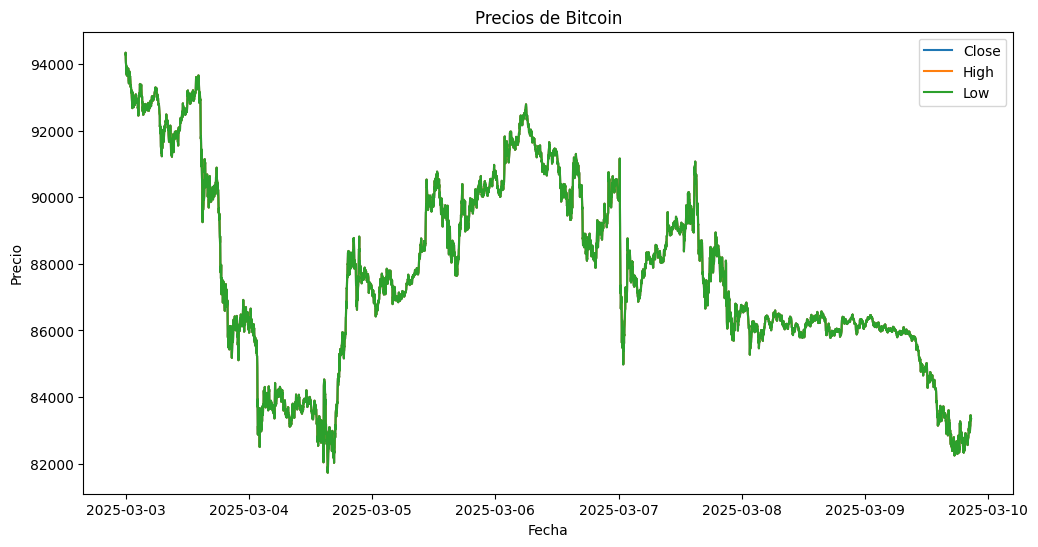

In [39]:
# Suponiendo que tu DataFrame se llama 'df' y las columnas que quieres graficar son 'Close', 'High', 'Low'
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura si lo necesitas

# Grafica cada columna con una etiqueta
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['High'], label='High')
plt.plot(df.index, df['Low'], label='Low')

# Agrega títulos y etiquetas
plt.title('Precios de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Muestra la leyenda para identificar las líneas
plt.legend()

# Muestra la gráfica
plt.show()

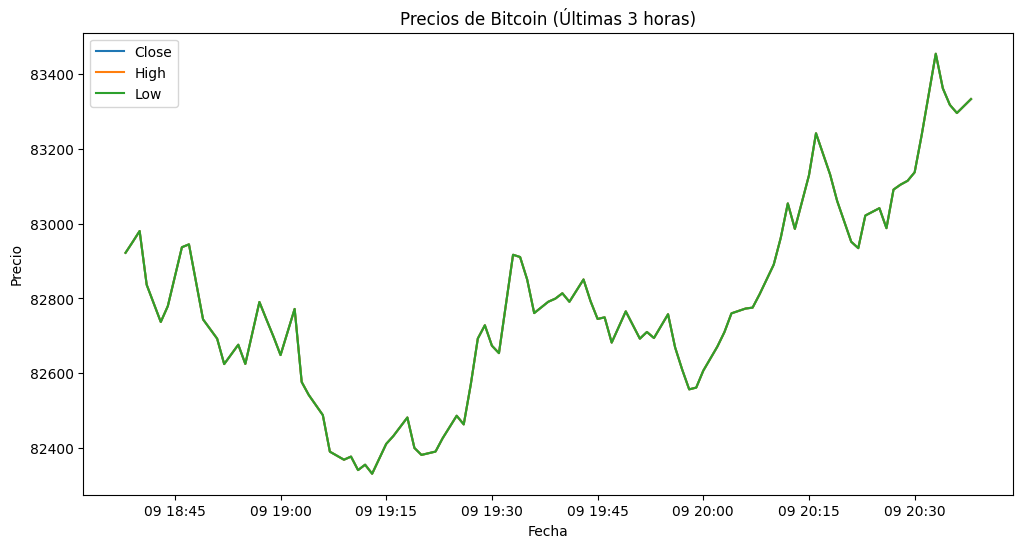

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# ... (tu código anterior) ...

# Filtrar el DataFrame para las últimas 3 horas
last_3_hours = df[df.index >= df.index[-1] - pd.Timedelta(hours=2)] #se calcula la hora actual - 3 horas

# Graficar las últimas 3 horas
plt.figure(figsize=(12, 6))
plt.plot(last_3_hours.index, last_3_hours['Close'], label='Close')
plt.plot(last_3_hours.index, last_3_hours['High'], label='High')
plt.plot(last_3_hours.index, last_3_hours['Low'], label='Low')

plt.title('Precios de Bitcoin (Últimas 3 horas)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [29]:

# Cargar tus datos (ejemplo)
data = df[["Close", "High", "Low"]].values

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Crear secuencias de datos
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), :])
        y.append(data[i+seq_length, 0])  # Predecir "Close"
    return np.array(X), np.array(y)

seq_length = 60  # Usar 60 minutos previos para predecir
X, y = create_sequences(scaled_data, seq_length)

# Dividir en train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [30]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 3)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0217 - val_loss: 9.7505e-05
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 4.6633e-04 - val_loss: 8.8426e-05
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 3.8580e-04 - val_loss: 9.8145e-05
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 4.1907e-04 - val_loss: 8.3292e-05
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 3.6564e-04 - val_loss: 7.0127e-05
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 2.8820e-04 - val_loss: 6.8647e-05
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 2.8599e-04 - val_loss: 6.6107e-05
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 2.9254e-04 - val_loss: 1.0872e-04
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 2.6229e-04 - val_loss: 5.3588e-05
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 2.0219e-04 - val_loss: 4.9943e-05
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21

In [36]:
def predict_next_30_minutes(model, last_sequence, scaler, steps=30):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(steps):
        # Predecir el próximo valor de "Close"
        next_pred = model.predict(current_sequence.reshape(1, seq_length, 3))
        predictions.append(next_pred[0,0])

        # Crear un nuevo paso temporal con valores dummy para High/Low
        new_step = np.array([[next_pred[0,0], 0, 0]])
        new_step = scaler.transform(new_step)  # Normalizar

        # Actualizar la secuencia
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = new_step

    # Invertir la normalización solo para la columna "Close"
    inverse_scaler = MinMaxScaler(feature_range=(0, 1))
    inverse_scaler.min_, inverse_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    return inverse_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

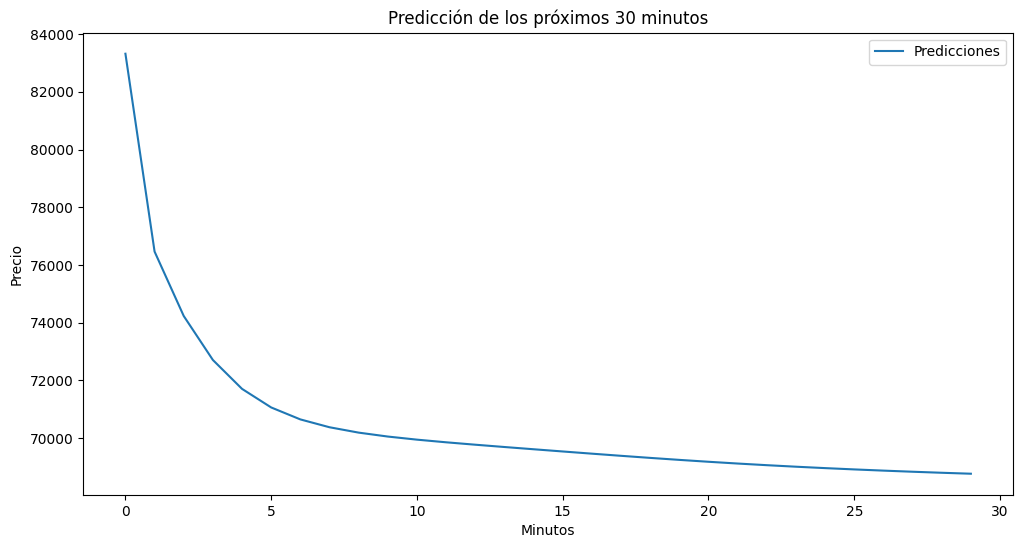

In [38]:
# Obtener la última secuencia del dataset
last_sequence = scaled_data[-seq_length:]

# Predecir
future_predictions = predict_next_30_minutes(model, last_sequence, scaler)

# Visualizar
plt.figure(figsize=(12,6))
plt.plot(future_predictions, label='Predicciones')
plt.title('Predicción de los próximos 30 minutos')
plt.xlabel('Minutos')
plt.ylabel('Precio')
plt.legend()
plt.show()